In [2]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(0)

In [10]:
n = 2500

data = {
    0: np.random.uniform(0, 1, (n, 2)),
    1: np.vstack((np.random.uniform(0, 1, n), np.random.beta(1.5, 2, n))).T,
    2: np.random.beta(1.5, 2, (n, 2))   
}

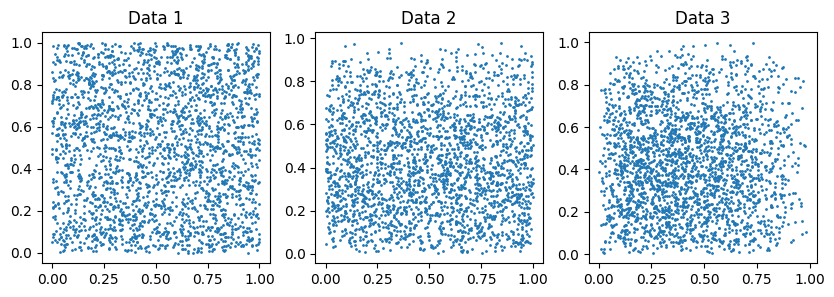

In [11]:
plt.figure(figsize=(10, 3))
for i in range(3):
    plt.subplot(1, 3, i+1)
    plt.scatter(data[i][:, 0], data[i][:, 1], s=1)
    plt.title("Data %d" % (i+1))

In [41]:
from scipy.sparse import csr_matrix
def selftune_rbf(distances, k_tune = 7)-> np.array:
    '''
        Inputs:
            distances: Euclidean distances between points, shape (n, n)
            ktune: number of nearest neighbors used to compute sigma
        Outputs:
            K: self tuned gaussian kernel, shape (n, n)
    '''
    n = distances.shape[0] 
    local_sigma = np.sort(distances, axis = 1)[:, k_tune + 1] # distance to k_tune-th point
    sigma = local_sigma.reshape(-1, 1) * local_sigma
    K = np.exp(-distances**2 / sigma)
    
    K[K < np.mean(K)] = 0
    return K

In [71]:
# construct k-nearest neighbor graph and self tuned gaussian kernel 
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.linalg import eigs
k = 24
k_tune = 7
knn_graph = {} # graph adjacency matrix
K = {} # self tuned gaussian kernel
distances = {} # Euclidean distances between points
unnormalized = {} # unnormalized laplacian, D - K
symmetric_normalized = {} # symmetric normalized laplacian, I - D^(-1/2)KD^(-1/2)
normalized = {} # random walk normalized laplacian, I - D^(-1)K
diffusion = {}# diffusion laplacian, K_bar = D^(-1)KD^(-1), D_bar = diag(sum(K_bar)), L = I - D_bar^(-1)K_bar

for i in range(3): 
    distances[i] = np.sqrt(np.sum((data[i].reshape(n, 1, 2) - data[i].reshape(1, n, 2))**2, axis=2))
    # knn_graph[i] = kneighbors_graph(data[i], n_neighbors=k, mode='connectivity')
    K[i] = selftune_rbf(distances[i], k_tune = k_tune)
    D = np.array(np.sum(K[i], axis=1)).squeeze()
    D_inv = np.diag(D**(-1))
    D_half = np.diag(D**(-0.5))
    
    k_bar = D_inv @ K[i] @ D_inv
    D_bar = np.diag(np.sum(k_bar, axis=1)**(-1))
    
    unnormalized[i] =  csr_matrix(D - K[i])
    symmetric_normalized[i] = csr_matrix(np.eye(n) - D_half @ K[i] @ D_half)
    normalized[i] = csr_matrix(np.eye(n) - D_inv @ K[i])
    diffusion[i] = csr_matrix(np.eye(n) - D_bar @ k_bar)
    
    
    eigvals, eigvecs = eigs(unnormalized[i])
    ord = np.argsort(eigvals)
    eigvals = eigvals[ord]
    eigvecs = eigvecs[:, ord]
    
    unnormalized[i+10] = eigvecs[:, 1:3]
    
    eigvals, eigvecs = eigs(symmetric_normalized[i])
    ord = np.argsort(eigvals)
    eigvals = eigvals[ord]
    eigvecs = eigvecs[:, ord]
    
    symmetric_normalized[i+10] = eigvecs[:, 1:3]
    
    eigvals, eigvecs = eigs(normalized[i])
    ord = np.argsort(eigvals)
    eigvals = eigvals[ord]
    eigvecs = eigvecs[:, ord]
    normalized[i+10] = eigvecs[:, 1:3]
    
    eigvals, eigvecs = eigs(diffusion[i])
    ord = np.argsort(eigvals)
    eigvals = eigvals[ord]
    eigvecs = eigvecs[:, ord]
    diffusion[i+10] = eigvecs[:, 1:3]
    

0
1
2


/opt/homebrew/lib/python3.11/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/homebrew/lib/python3.11/site-packages/matplotlib/collections.py:194: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)


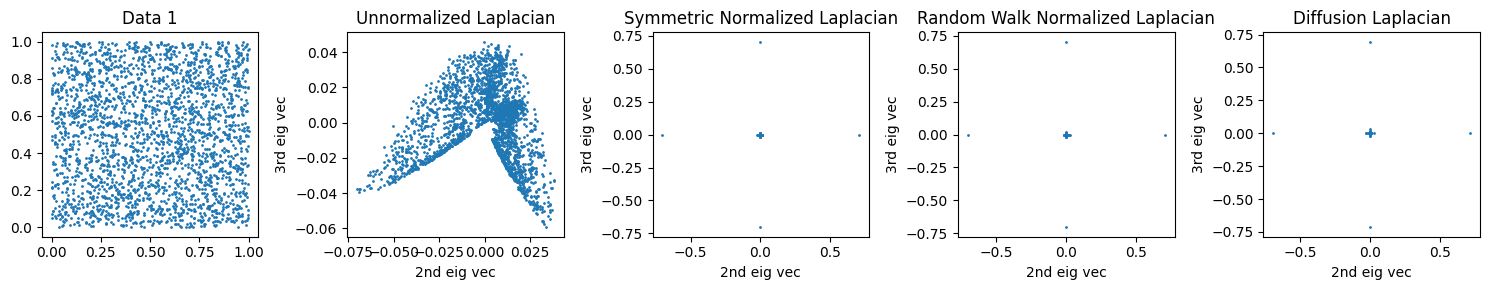

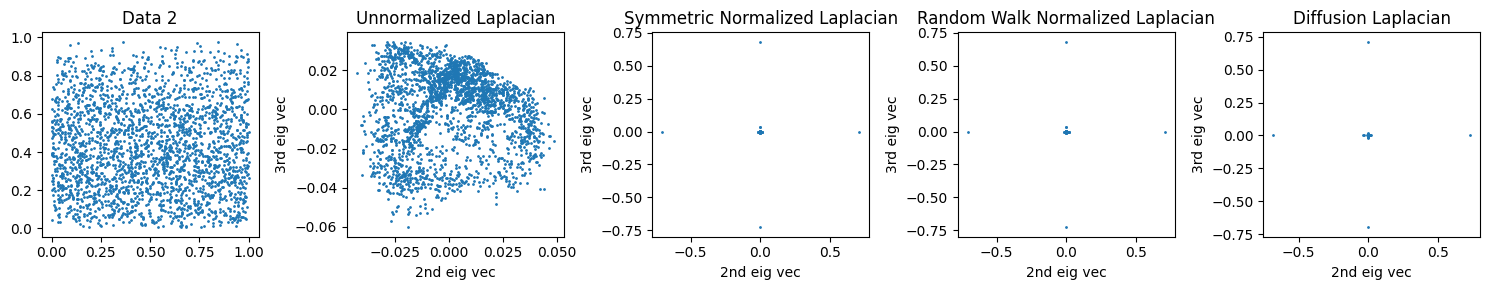

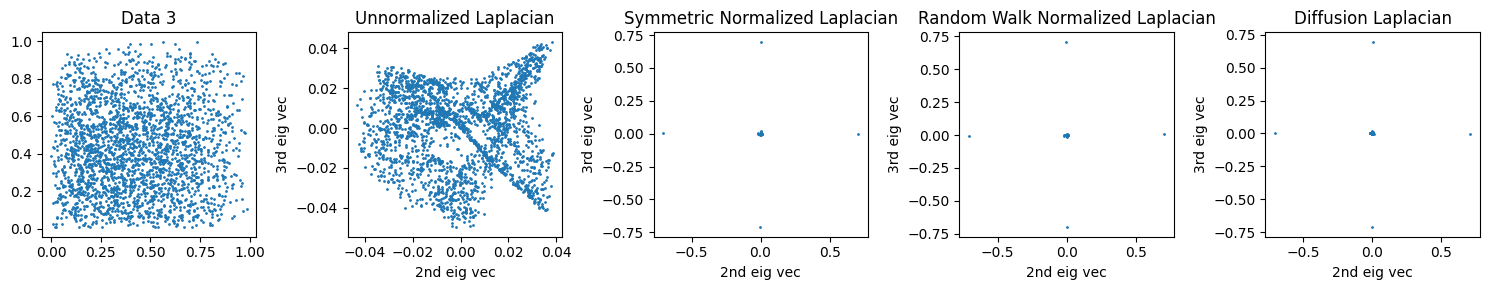

In [81]:
for i in range(3):
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 5, 1)
    plt.scatter(data[i][:, 0], data[i][:, 1], s=1)
    plt.title("Data %d" % (i+1))
    plt.subplot(1, 5, 2)
    plt.scatter(unnormalized[i+10][:, 0], unnormalized[i+10][:, 1], s=1)
    plt.title("Unnormalized Laplacian")
    plt.xlabel('2nd eig vec')
    plt.ylabel('3rd eig vec')
    plt.subplot(1, 5, 3)
    plt.scatter(symmetric_normalized[i+10][:, 0], symmetric_normalized[i+10][:, 1], s=1)
    plt.title("Symmetric Normalized Laplacian")
    plt.xlabel('2nd eig vec')
    plt.ylabel('3rd eig vec')
    plt.subplot(1, 5, 4)
    plt.scatter(normalized[i+10][:, 0], normalized[i+10][:, 1], s=1)
    plt.title("Random Walk Normalized Laplacian")
    plt.xlabel('2nd eig vec')
    plt.ylabel('3rd eig vec')
    plt.subplot(1, 5, 5)
    plt.scatter(diffusion[i+10][:, 0], diffusion[i+10][:, 1], s=1)
    plt.title("Diffusion Laplacian")
    plt.xlabel('2nd eig vec')
    plt.ylabel('3rd eig vec')
    
    plt.tight_layout()
    plt.savefig('Q4_gaussian_kernel_data_%d.png' % i)

In [78]:
# construct k-nearest neighbor graph and self tuned gaussian kernel 
from sklearn.neighbors import kneighbors_graph
from scipy.sparse.linalg import eigs
k = 24
k_tune = 7
knn_graph = {} # graph adjacency matrix
K = {} # self tuned gaussian kernel
distances = {} # Euclidean distances between points
unnormalized = {} # unnormalized laplacian, D - K
symmetric_normalized = {} # symmetric normalized laplacian, I - D^(-1/2)KD^(-1/2)
normalized = {} # random walk normalized laplacian, I - D^(-1)K
diffusion = {}# diffusion laplacian, K_bar = D^(-1)KD^(-1), D_bar = diag(sum(K_bar)), L = I - D_bar^(-1)K_bar

for i in range(3):
    print(i)
    distances[i] = np.sqrt(np.sum(np.abs(data[i].reshape(n, 1, 2) - data[i].reshape(1, n, 2)), axis=2))
    # knn_graph[i] = kneighbors_graph(data[i], n_neighbors=k, mode='connectivity')
    K[i] = selftune_rbf(distances[i], k_tune = k_tune)
    D = np.array(np.sum(K[i], axis=1)).squeeze()
    D_inv = np.diag(D**(-1))
    D_half = np.diag(D**(-0.5))
    
    k_bar = D_inv @ K[i] @ D_inv
    D_bar = np.diag(np.sum(k_bar, axis=1)**(-1))
    
    unnormalized[i] =  csr_matrix(D - K[i])
    symmetric_normalized[i] = csr_matrix(np.eye(n) - D_half @ K[i] @ D_half)
    normalized[i] = csr_matrix(np.eye(n) - D_inv @ K[i])
    diffusion[i] = csr_matrix(np.eye(n) - D_bar @ k_bar)
    
    
    eigvals, eigvecs = eigs(unnormalized[i])
    ord = np.argsort(eigvals)
    eigvals = eigvals[ord]
    eigvecs = eigvecs[:, ord]
    
    unnormalized[i+10] = eigvecs[:, 1:3]
    
    eigvals, eigvecs = eigs(symmetric_normalized[i])
    ord = np.argsort(eigvals)
    eigvals = eigvals[ord]
    eigvecs = eigvecs[:, ord]
    
    symmetric_normalized[i+10] = eigvecs[:, 1:3]
    
    eigvals, eigvecs = eigs(normalized[i])
    ord = np.argsort(eigvals)
    eigvals = eigvals[ord]
    eigvecs = eigvecs[:, ord]
    normalized[i+10] = eigvecs[:, 1:3]
    
    eigvals, eigvecs = eigs(diffusion[i])
    ord = np.argsort(eigvals)
    eigvals = eigvals[ord]
    eigvecs = eigvecs[:, ord]
    diffusion[i+10] = eigvecs[:, 1:3]
    

0
1
2


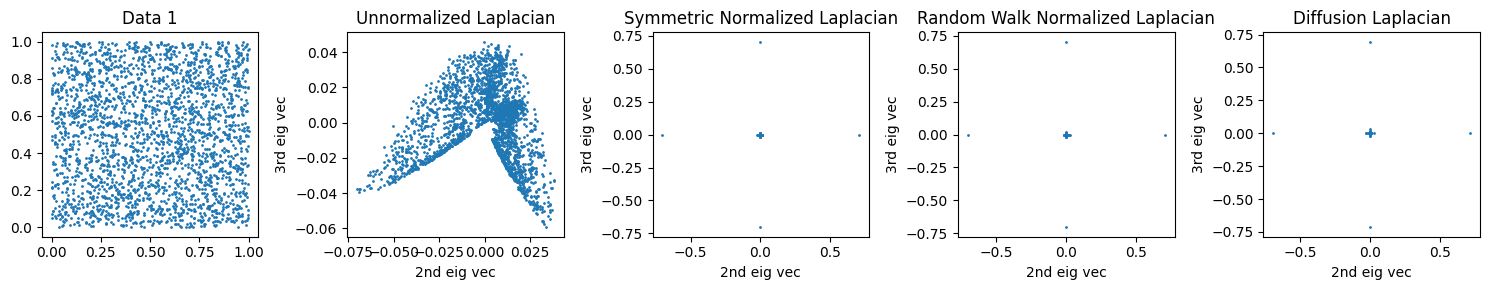

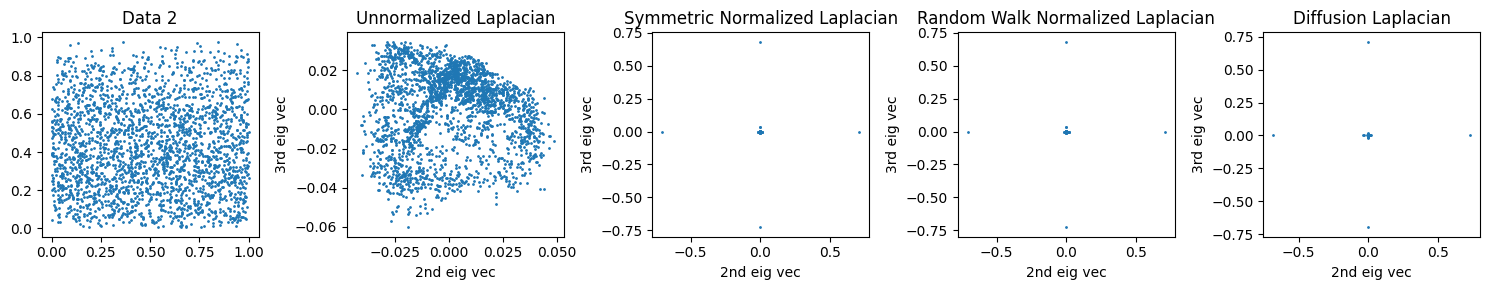

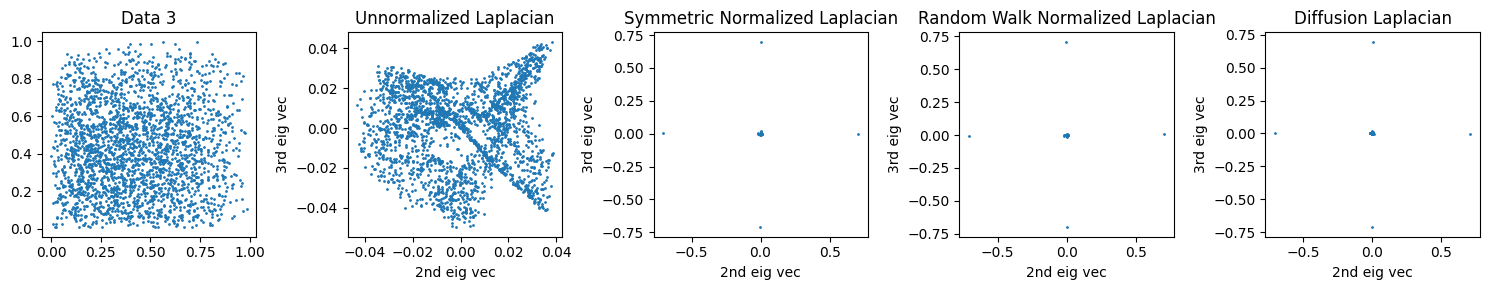

In [82]:
for i in range(3):
    plt.figure(figsize=(15, 3))
    plt.subplot(1, 5, 1)
    plt.scatter(data[i][:, 0], data[i][:, 1], s=1)
    plt.title("Data %d" % (i+1))
    plt.subplot(1, 5, 2)
    plt.scatter(unnormalized[i+10][:, 0], unnormalized[i+10][:, 1], s=1)
    plt.title("Unnormalized Laplacian")
    plt.xlabel('2nd eig vec')
    plt.ylabel('3rd eig vec')
    plt.subplot(1, 5, 3)
    plt.scatter(symmetric_normalized[i+10][:, 0], symmetric_normalized[i+10][:, 1], s=1)
    plt.title("Symmetric Normalized Laplacian")
    plt.xlabel('2nd eig vec')
    plt.ylabel('3rd eig vec')
    plt.subplot(1, 5, 4)
    plt.scatter(normalized[i+10][:, 0], normalized[i+10][:, 1], s=1)
    plt.title("Random Walk Normalized Laplacian")
    plt.xlabel('2nd eig vec')
    plt.ylabel('3rd eig vec')
    plt.subplot(1, 5, 5)
    plt.scatter(diffusion[i+10][:, 0], diffusion[i+10][:, 1], s=1)
    plt.title("Diffusion Laplacian")
    plt.xlabel('2nd eig vec')
    plt.ylabel('3rd eig vec')
    
    plt.tight_layout()
    plt.savefig('Q4_laplacian_kernel_data_%d.png' % i)